# Proba project - Clustering based on information theory.
In this work, we implemented the clustering algorithm based on information theory, then tested it on 4 different datasets:

**Artificial datasets:**
- ds1
- ds2

**Real world datasets:**
- SP500
- MOVIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Clustering algorithm
We first implement the clutering algorithm according to the main idea of the article.

The 3 main functions of the algorithm are:
- **\_\_init\_\_** : get input value, initialize the $P(C|i)$ as a random (normalized) distribution and initialize all the parameters.
- **fit**: update $P(C|i)$ until converge.
- **update**: compute and update $P(C),P(i|C),S(C),S(C;i)$ according to $P(C|i)$.

We also implement 4 extensions:
- **predict**: return the label of cluster predicted for each element based on $P(C|i)$.
- **local_minimum**: compute and return $<S>$, $I(C;i)$ and $F = <S> - T*I(C;i)$.
- **display_parameters**: display all the parameters including $F,<S>,I(C;i),S(C),P(C), deterministic$ $rate$ which are necessary for analysation.
- **sort**: sort the cluster finded by $S(C)$ and sort the elements in each cluster by $S(C;i)$, which is used for visualization.
- **deterministic_rate**: Return the percentage of the elements had a nearly deterministic assignment. ($P (C|i) > 0.9$ for a particular $C$)


In [133]:
class clustering:
    
    def __init__(self,simil,T,N_c,ε):
        
        self.simil = simil
        self.T = T
        self.N_c = N_c
        self.ε = ε
        
        '''initialize'''
        
        self.N = simil.shape[0]
        self.m = 0
        
        self.P_i = 1/self.N
        self.P_c = np.zeros(self.N_c)
        self.P_ci = np.zeros((self.N,self.N_c))
        self.P_ic = np.zeros((self.N_c,self.N))
        
        self.S_c = np.zeros(self.N_c)
        self.S_ci = np.zeros((self.N,self.N_c))

        '''set P(C|i) as a random (normalized) distribution'''
        
        for i in range(self.N): 
            r_list = np.array(list(np.random.random() for _ in range(self.N_c)))
            r_list = r_list/sum(r_list)
            self.P_ci[i] = r_list
        
        '''and update all the parameters with P(C|i)'''
        
        self.update_value()
        
        
    def fit(self):
        
        '''initialize a new matrix for P(m+1)(C|i)'''
        
        P_ci_new = np.zeros((self.N,self.N_c))
        
        stop = 0
        
        while stop == 0:
            
            '''compute P(m+1)(C|i) according to formula [7] in article'''
            
            for i in range(self.N):
                for c in range(self.N_c):
                    P_ci_new[i][c] = self.P_c[c]*np.exp((1/self.T) * (2*self.S_ci[i][c] - self.S_c[c]))
                P_ci_new[i] = P_ci_new[i]/sum(P_ci_new[i])
               
            self.m += 1
            stop = 1
            
            
            '''check if all the |P(m+1)(C|i) - P(m)(C|i)| <= ε'''
            
            for i in range(self.N):
                for c in range(self.N_c):
                    if abs(P_ci_new[i][c] - self.P_ci[i][c]) > self.ε:
                        stop = 0
                        continue
            
            '''update P(m)(C|i)'''
            
            for i in range(self.N):
                for c in range(self.N_c):
                    self.P_ci[i][c] = np.nan_to_num(P_ci_new[i][c]) #replace nan by 0 to avoid underflow

            '''and update all the parameters with new P(m)(C|i)'''
            
            self.update_value()
            
            if self.m >= 200:
                stop = 1
            
        print("Iteration times:",self.m)
    
    
    def predict(self):
        
        '''return the cluster with the highest probability P(C|i) as the cluster predicted'''
        
        predict_label = list(np.argmax(self.P_ci[i]) for i in range(self.N))
        
        return predict_label
    
    
    def local_minimum(self):
        
        '''compute <S>, I(C;i) and F, return the local minimun'''
        
        S = self.P_c.T @ self.S_c
        
        I = 0.
        for i in range(self.N):
            for c in range(self.N_c):
                if self.P_ci[i][c] != 0:
                    I +=  np.nan_to_num(self.P_ci[i][c]*np.log(self.P_ci[i][c]/self.P_c[c]))
                
        I = I/self.N
        
        F = S-self.T*I
        
        return F,S,I
    
    
    def display_parameters(self):
        
        '''display all the parameters necessary'''
        
        F,S,I = self.local_minimum()
        
        print('F =',F)
        print('S =',S)
        print('I =',I)
        print('S_c =',self.S_c)
        print('P_c =',self.P_c)
        print('deterministic_rate = ',self.deterministic_rate())
        
        
    def update_value(self):
            
        '''compute P(C): P(C) = sum(P(C|i)*P(i))'''
        
        for c in range(self.N_c):
            self.P_c[c] = sum(self.P_ci[:,c] * self.P_i)
        
        '''compute P(i|C) according to Bayes' theorem'''
        
        for c in range(self.N_c):
            for j in range(self.N):
                self.P_ic[c][j] = self.P_ci[j][c] * self.P_i / self.P_c[c]
        
        '''compute S(C) according to formula [1] in article'''

        for c in range(self.N_c):
            self.S_c[c] = 0.
            for i in range(self.N):
                for j in range(self.N):
                    self.S_c[c] += self.P_ic[c][i] * self.P_ic[c][j] * self.simil[i][j]
        
        '''compute S(C;i) according to formula [6] in article'''

        for c in range(self.N_c):
            for i in range(self.N):
                self.S_ci[i][c] = 0.
                for j in range(self.N):
                    self.S_ci[i][c] += self.P_ic[c][j] * self.simil[i][j]

                    
    def deterministic_rate(self):
        
        '''
        The percentage of the elements had a nearly deterministic assignment
        [P (C|i) > 0.9 for a particular C]
        '''
        count = 0
        
        for elem in self.P_ci:
            for p in elem:
                if p >= 0.9:
                    count += 1
                    continue
                    
        percentage = round(count/self.N,3)
        
        return percentage

    
    def sort(self):

        '''sort the cluster according to the S(C)'''
        
        clusters_sorted = np.argsort(-self.S_c)
        cluster_dict = {}
        label = self.predict()
        
        '''build a library for the clusters sorted and their corresponding elements'''
        
        for c in clusters_sorted:
            for i,c_i in enumerate(label):
                if c_i == c:
                    cluster_dict.setdefault(c,[]).append(i)
        
        '''
        sort the elements according to the S(C;i)
        S(C;i): the similarity between i and the other elements in the same cluster
        '''
        
        element_list = []

        for c in cluster_dict.keys():
            S_ci_temp = []
            for i in cluster_dict[c]:
                S_ci_temp.append(self.S_ci[i][c])

            element_list.extend(list(np.array(cluster_dict[c])[np.argsort(-np.array(S_ci_temp))]))
        
        '''build an permutation matrix P and reorder the similarity matrix'''
        
        mat_P = np.zeros((self.N,self.N))

        for i,elem in enumerate(element_list):
            mat_P[elem][i] = 1
        
        mat_simil_sorted = mat_P.T @ self.simil @ mat_P
        
        '''return the similarity matrix reordered'''
        
        return mat_simil_sorted
    

## Artificial dataset:
### ds1
The data from this dataset is quite simple and labeled, we use this dataset to check whether our clustering algorithm can achieve reasonable results and find out the suitable $T$ and $\epsilon$.

In [141]:
def visualize(data,label,N_c):

    clusters = [[] for _ in range(N_c)]
    
    N = data.shape[0]
    for i in range(N):
        for c in range(N_c):
            if label[i] == c:
                clusters[c].append(data[i])
                
    plt.figure()
    colors = 'rgbycm'
    for c in range(N_c):
        clusters[c] = np.array(clusters[c])
        if clusters[c].size != 0:
            plt.scatter(clusters[c][:,0],clusters[c][:,1],c=colors[c]) 
            plt.xlabel('x')
            plt.ylabel('y')

In [58]:
file = open("./dataset/scatter_ds1.d")

data = []
label = []

for line in file:
    line = line.strip().split(' ')
    data.append([float(line[0]),float(line[1])])
    label.append(int(line[2]))

data = np.array(data)
label = np.array(label)

In [59]:
file = open('./dataset/simil_ds1.d')

mat_simil = []

for line in file:
    line = line.strip().split(' ')
    mat_simil.append(list(float(line[i]) for i in range(len(line))))

mat_simil = np.array(mat_simil)

In [60]:
print(data.shape)
print(label.shape)
print(mat_simil.shape)

(300, 2)
(300,)
(300, 300)


- Step for Choosing $T$:

    From the plot we can see that the $<S>$ is already saturated when $T = \frac{1}{5}$, to be conservative, we use $\frac{1}{10}$ for $T$.

In [147]:
s_list = []

t_list = [1/10,1,2,5,10,15,20]
for t in t_list:
    cluster = clustering(mat_simil,1/t,3,0.01)
    cluster.fit()
    _,S,_ = cluster.local_minimum()
    s_list.append(S)

Iteration times: 2
Iteration times: 13
Iteration times: 9
Iteration times: 9
Iteration times: 8
Iteration times: 11
Iteration times: 8


Text(0, 0.5, '<S>')

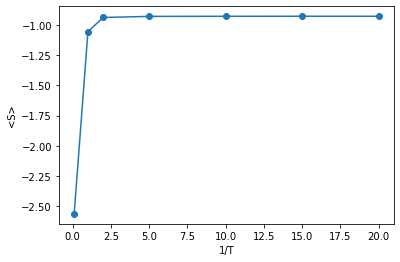

In [149]:
plt.figure()
plt.plot(t_list,s_list,marker='o')
plt.xlabel('1/T')
plt.ylabel('<S>')

- Step for Choosing $\epsilon$:

    From the plot we can see that the $<S>$ is already saturated when $\epsilon = 0.1$, to be conservative, we use $\epsilon = 0.01$.

In [135]:
s_list = []

e_list = [1,0.1,0.01,0.001,0.0001]
for e in e_list:
    cluster = clustering(mat_simil,0.1,3,e)
    cluster.fit()
    _,S,_ = cluster.local_minimum()
    s_list.append(S)

Iteration times: 1
Iteration times: 4
Iteration times: 8
Iteration times: 10
Iteration times: 12


Text(0, 0.5, '<S>')

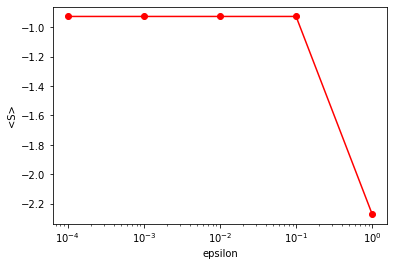

In [136]:
plt.figure()
plt.plot(e_list,s_list,marker='o',color='r')
plt.xscale('log')
plt.xlabel('epsilon')
plt.ylabel('<S>')

- Train the clustering algo with $T = \frac{1}{10}, \epsilon = 0.01$, then visualize the result and comparing with the real label:

In [137]:
cluster = clustering(mat_simil,1/10,3,0.01)
cluster.fit()

F = -2.5783285396006237
S = -2.563281761624257
I = 0.15046777976366704
S_c = [-2.50928472 -2.59345908 -2.59052377]
P_c = [0.347439   0.33509408 0.31746692]
deterministic_rate =  0.01
Iteration times: 10


In [138]:
predict_label = cluster.predict()
cluster.display_parameters()

F = -1.034229463496409
S = -0.927164577478627
I = 1.0706488601778208
S_c = [-0.96930782 -0.81249408 -0.99210336]
P_c = [0.24707537 0.33019768 0.42272695]
deterministic_rate =  0.993


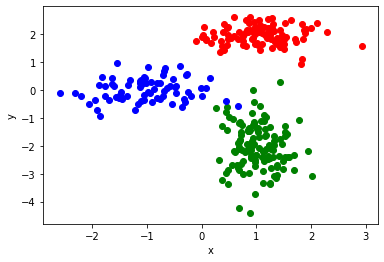

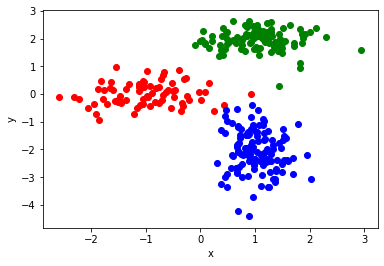

In [142]:
'''compare to the real label, the algo works well.'''
visualize(data,label,3)
visualize(data,predict_label,3)

- sort and visualize the similarity matrix.

In [312]:
mat_simil_sorted = cluster.sort()

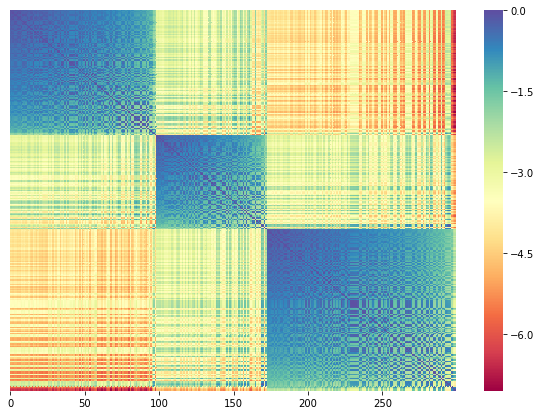

In [313]:
'''With the heatmap we can see that the elements in the same cluster are highly related.'''
plt.figure(figsize=(10,7))
ax = sns.heatmap(mat_simil_sorted,xticklabels=50, yticklabels=False, cmap='Spectral')
plt.show()

### ds2
In this dataset, only the similarity matrix is given. We try to find out the number of clusters in this dataset by executing the algorithm and analyse the $S(C)$ obtained with different number of clusters $N_c$ and a fixed $T$.

In [144]:
file = open('./dataset/simil_ds2.d')

mat_simil1 = []

for line in file:
    line = line.strip().split(' ')
    mat_simil1.append(list(float(line[i]) for i in range(len(line))))

mat_simil1 = np.array(mat_simil1)

In [236]:
s_list = []

for c in range(2,10):
    cluster = clustering(mat_simil1,1/20,c,0.01)
    cluster.fit()
    _,S,_ = cluster.local_minimum()
    s_list.append(S)

Iteration times: 6
Iteration times: 4
Iteration times: 8
Iteration times: 20
Iteration times: 24
Iteration times: 23
Iteration times: 20
Iteration times: 37



- From the result we can see that the slope of the curve drops significantly from the 4th point，which means that there exits probably **4 clusters** in the dataset.


Text(0, 0.5, '<S>')

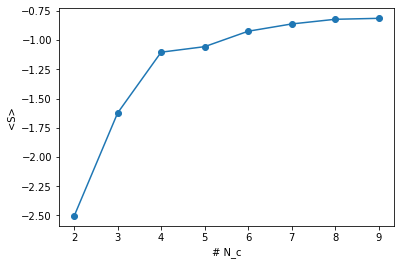

In [304]:
plt.figure()
plt.plot([i for i in range(2,10)],s_list,marker='o')
plt.xlabel('# N_c')
plt.ylabel('<S>')

- The sorted similarity matrix can support our result.

In [145]:
cluster = clustering(mat_simil1,0.1,4,0.01)
cluster.fit()
mat_simil_sorted = cluster.sort()

Iteration times: 11


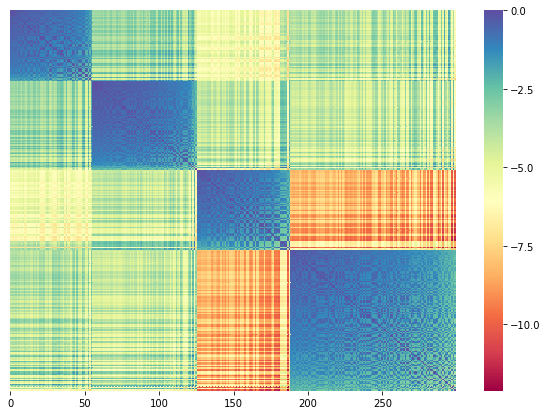

In [146]:
plt.figure(figsize=(10,7))
ax = sns.heatmap(mat_simil_sorted,xticklabels=50, yticklabels=False, cmap='Spectral')
plt.show()

## Real world dataset
### SP500

In [4]:
fileSP_simil = open('./dataset/SP500/mi_sp500.d')
fileSP_matType = open('./dataset/SP500/sp500_matType.d')

dataSP_simil = []
dataSP_matType = []

for line in fileSP_simil:
    line = line.strip().split(' ')
    dataSP_simil.append(list(float(line[i]) for i in range(len(line))))
    
for line in fileSP_matType:
    line = line.strip().split(' ')
    dataSP_matType.append(list(float(line[i]) for i in range(len(line))))
    
dataSP_simil = np.array(dataSP_simil)
dataSP_matType = np.array(dataSP_matType)

In [5]:
print(dataSP_simil.shape)
print(dataSP_matType.shape)

(501, 501)
(501, 208)


- Step for Choosing $T$:

    From the plot we can see that the $<S>$ is already saturated when $T = \frac{1}{5}$, to be conservative, we use $\frac{1}{10}$ for $T$.

In [365]:
s_list_SP = []
i_list_SP = []
d_list_SP = []
t_list_SP = [1/5,1/10,1/15,1/20,1/25,1/30,1/35,1/40]
for t in t_list_SP:
    cluster_SP = clustering(dataSP_simil,t,20,0.01)
    cluster_SP.fit()
    _,S,I = cluster_SP.local_minimum()
    s_list_SP.append(S)
    i_list_SP.append(I)
    d_list_SP.append(cluster_SP.deterministic_rate())

Iteration times: 2
Iteration times: 2
Iteration times: 3
Iteration times: 3
Iteration times: 91
Iteration times: 108
Iteration times: 83
Iteration times: 22


In [366]:
print(s_list_SP)
print(i_list_SP)
print(d_list_SP)

[0.10538272568853557, 0.10538494791902883, 0.10539446085690928, 0.10546151081208002, 0.2167332645411796, 0.26692946753010166, 0.26502101489168106, 0.2668823039759989]
[6.795525985125789e-06, 6.109412063189192e-05, 0.00022314481035233378, 0.0014207948415116002, 1.3771448045713748, 2.3395885544415798, 2.6953009051787773, 2.9238261969889865]
[0.0, 0.0, 0.0, 0.0, 0.317, 0.996, 0.99, 1.0]


Text(0, 0.5, 'deterministic (%)')

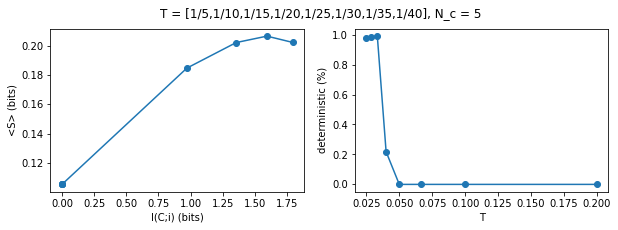

In [359]:
f,ax = plt.subplots(1,2,figsize=(10,3))
plt.suptitle('T = [1/5,1/10,1/15,1/20,1/25,1/30,1/35,1/40], N_c = 5')

ax[0].plot(i_list_SP,s_list_SP,marker='o')
ax[0].set_xlabel('I(C;i) (bits)')
ax[0].set_ylabel('<S> (bits)')
ax[1].plot(t_list_SP,d_list_SP,marker='o')
ax[1].set_xlabel('T')
ax[1].set_ylabel('deterministic (%)')

In [355]:
fileSP_si = open('./dataset/SP500/sp500_SI.d')

dataSP_si= []


for line in fileSP_si:
    line = line.strip().split(' ')
    dataSP_si.append(list(float(line[i]) for i in range(len(line))))
    

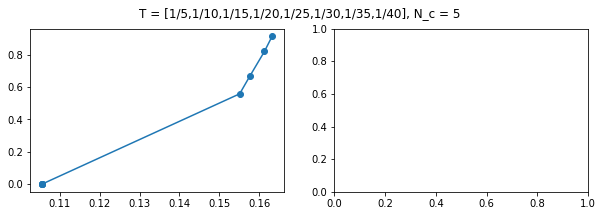

In [356]:
f,ax = plt.subplots(1,2,figsize=(10,3))
plt.suptitle('T = [1/5,1/10,1/15,1/20,1/25,1/30,1/35,1/40], N_c = 5')

ax[0].plot(dataSP_si[0],dataSP_si[1],marker='o')

In [116]:
cluster_SP = clustering(dataSP_simil,1/500,20,0.01)
cluster_SP.fit()

Iteration times: 11


In [117]:
predict_label_SP = cluster_SP.predict()
cluster_SP.display_parameters()

F = 0.22180414891280786
S = 0.2277261730689279
I = 2.9610120780600155
S_c = [0.30574332 0.23345941 0.21336614 0.22155029 0.20599572 0.17808762
 0.25545886 0.23615438 0.33551427 0.1918913  0.14919743 0.25208159
 0.16306388 0.16979919 0.10374055 0.27898126 0.25088341 0.23624305
 0.41132661 0.24877898]
P_c = [0.04191617 0.05189627 0.04790189 0.04590819 0.03992016 0.04590818
 0.05189629 0.04391218 0.05389222 0.04391218 0.05988024 0.03592814
 0.04790419 0.06786429 0.08183874 0.08183594 0.02794411 0.03992016
 0.05189611 0.03792435]
deterministic_rate =  1.0


In [118]:
mat_simil_sorted_SP = cluster_SP.sort()

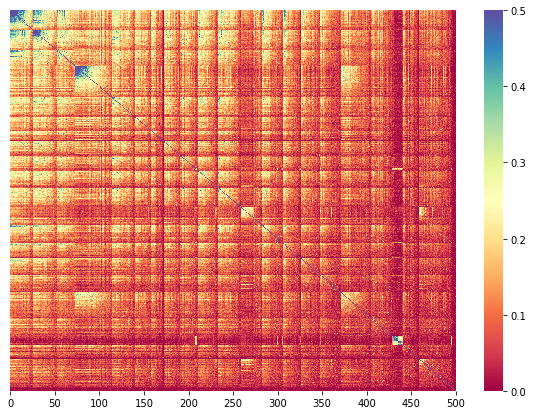

In [119]:
plt.figure(figsize=(10,7))
ax = sns.heatmap(mat_simil_sorted_SP,xticklabels=50, yticklabels=False,vmin=0, vmax=0.5, cmap='Spectral')
plt.show()

### MOVIES

In [10]:
fileMovie_simil = open('./dataset/MOVIES/mi_movie.d')
fileMovie_matType = open('./dataset/MOVIES/movie_labels.d')

dataMovie_simil = []
dataMovie_matType = []

for line in fileMovie_simil:
    line = line.strip().split(' ')
    dataMovie_simil.append(list(float(line[i]) for i in range(len(line))))
    
for line in fileMovie_matType:
    line = line.strip().split(' ')
    dataMovie_matType.append(list(float(line[i]) for i in range(len(line))))
    
dataMovie_simil = np.array(dataMovie_simil)
dataMovie_matType = np.array(dataMovie_matType)

In [11]:
print(dataMovie_simil.shape)
print(dataMovie_matType.shape)

(500, 500)
(500, 10)


In [12]:
print(dataMovie_matType[0])

[1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [17]:
s_list_Movie = []
i_list_Movie = []
d_list_Movie = []
t_list_Movie = [1/5,1/10,1/15,1/20,1/25,1/30,1/35,1/40]
for t in t_list_Movie:
    cluster_Movie = clustering(dataMovie_simil,t,15,0.01)
    cluster_Movie.fit()
    _,S,I = cluster_Movie.local_minimum()
    s_list_Movie.append(S)
    i_list_Movie.append(I)
    d_list_Movie.append(cluster_Movie.deterministic_rate())

Iteration times: 2
Iteration times: 3
Iteration times: 4
Iteration times: 12
Iteration times: 200
Iteration times: 200
Iteration times: 200
Iteration times: 200


In [18]:
print(s_list_Movie)
print(i_list_Movie)
print(d_list_Movie)

[0.10817192214189181, 0.1081719225876747, 0.10817302781724504, 0.10818104056522165, 0.17830292781783447, 0.17988806363258472, 0.17787300086811195, 0.178493904273514]
[4.604455855143238e-06, 8.150096632709645e-06, 6.1024097449099175e-05, 0.00022115417864292558, 0.5307932659979145, 0.8568882484646896, 1.0174694486588545, 1.2454382092770373]
[0.0, 0.0, 0.0, 0.0, 0.09, 0.256, 0.41, 0.558]


In [129]:
cluster_Movie = clustering(dataMovie_simil,1/500,20,0.01)
cluster_Movie.fit()

Iteration times: 5


In [130]:
predict_label_Movie = cluster_Movie.predict()
cluster_Movie.display_parameters()
print(cluster_Movie.deterministic_rate())

F = 0.21162522515586396
S = 0.21755867284249888
I = 2.966723843317465
S_c = [0.2408916  0.23231014 0.13567521 0.17390419 0.27500029 0.18801741
 0.32317151 0.19734743 0.23369018 0.20325677 0.18499932 0.27447437
 0.12889399 0.29644125 0.19827495 0.15920285 0.34900609 0.2940464
 0.23357642 0.15802713]
P_c = [0.042 0.044 0.076 0.054 0.032 0.042 0.046 0.052 0.084 0.044 0.054 0.048
 0.058 0.044 0.046 0.052 0.052 0.034 0.036 0.06 ]
deterministic_rate =  1.0
1.0


In [131]:
mat_simil_sorted_Movie = cluster_Movie.sort()

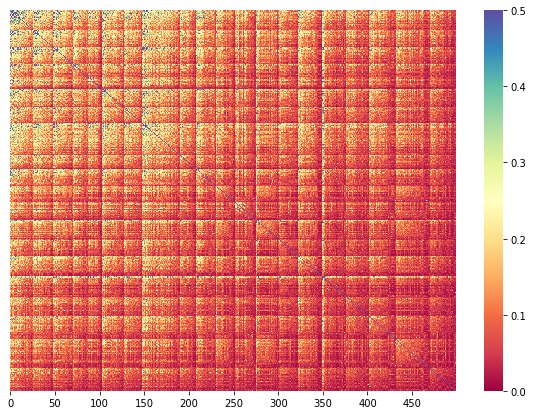

In [132]:
plt.figure(figsize=(10,7))
ax = sns.heatmap(mat_simil_sorted_Movie,xticklabels=50, yticklabels=False,vmin=0, vmax=0.5, cmap='Spectral')
plt.show()